### Overview

In this notebook,
we try to determine if the following extremely simple setup can cliff.

Assume data $\mathsf{x} \in \mathbb{R}^d, \mathsf{y} \in \{\pm 1\}$
is distributed according to

$$
\begin{align*}
    \mathsf{y} &\sim \text{Unif}(\{\pm 1\}) \\
    \mathsf{x} &\sim \mathcal{N}(\mathsf{y} \cdot \mu, \Sigma)
\end{align*}
$$

Moreover, assume that we have $n$ i.i.d.
training datapoints $\{(\mathsf{x}_i, \mathsf{y}_i)\}_{i=1}^n$.

We will attempt to learn a linear classifier to predict
$\mathsf{y}$ from $\mathsf{x}$.
Our linear classifier will take the form

$$
f_{w}(x) = \text{sign}(w^\top x)
$$

We will learn our linear classifier using the following learning algorithm:

$$
\hat{\mathsf{w}} = \frac{1}{n} \sum_{i=1}^n \mathsf{y}_i \mathsf{x}_i.
$$

Note that a linear change of coordinates
does not effect the performance of our learning algorithm.

Thus without loss of generality we can assume that $\Sigma = I_d$
and $\mu \propto e_1$.

### Error calculation
For a fixed $w$, the test error of $f_w$ is

$$
\begin{align*}
\mathbb{P}(f_w(\mathsf{x}) \neq \mathsf{y})
&= \mathbb{P}(\text{sign}(w^\top \mathsf{x}) \neq \mathsf{y}) \\
&= \mathbb{P}(w^\top \mathsf{x} \cdot \mathsf{y} < 0) \\
&= \mathbb{P}(w^\top \mathcal{N}(\mu, \Sigma) < 0) \\
&= \mathbb{P}(\mathcal{N}(w^\top \mu, \,w^\top \Sigma w) < 0) \\
&= \Phi\left(- \frac{w^\top \mu}{\sqrt{w^\top \Sigma w}}\right) \\
\end{align*}
$$

where $\Phi$ is the cumulative distribution function of the standard normal distribution.

Assuming WLOG that $\Sigma = I_d$,
we can simplify the above expression to

$$
\text{err}(f_w) = \Phi\left(-\frac{w^\top \mu}{\|w\|_2}\right)
$$


### Efficient simulation
Now let $\ell = \|\mu\|_2$
and $\epsilon \sim \mathcal{N}(0, 1)$.

Then $\alpha(n) \triangleq w^\top \mu / \|w\|_2$ has the same distribution as
$$
\frac{\displaystyle l^2 + \frac{l\epsilon}{\sqrt{n}}}
{\sqrt{\displaystyle l^2 + \frac{2l\epsilon}{\sqrt{n}} + \frac{\epsilon^2 + \chi^2_{d - 1}}{n}}},
$$
where $\chi^2_{d - 1}$ is a $\chi^2$ random variable with $d - 1$ degrees of freedom.

Then $\|w\|_2^2 - \alpha(n)^2$
has the same distribution as
$$
\Delta_2(n) \triangleq \frac{\chi^2_{d - 1}}
{\displaystyle n \left(1 + \frac{2\epsilon}{l\sqrt{n}} + \frac{\epsilon^2 + \chi^2_{d - 1}}{l^2n} \right)}.
$$

So
$$
\alpha(n) = \|w\|_2 - \frac{\Delta_2(n)}{2\|w\|_2} + o(1/n)
=  \|w\|_2 - \frac{\chi^2_{d - 1}}{2n\|w\|_2} + o(1/n).
$$


### Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pathlib
import sys

import git.repo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.special
import scipy.stats
from tqdm import tqdm

GIT_ROOT = pathlib.Path(
    str(git.repo.Repo(".", search_parent_directories=True).working_tree_dir)
)
sys.path.append(str(GIT_ROOT))

from src import stylesheets

### Convenience functions

0.003071191869868973 0.003071191869868971 -2.512693050563651


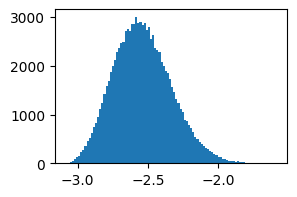

In [3]:
def get_opt_err(mu: np.ndarray) -> float:
    return scipy.special.ndtr(-np.linalg.norm(mu))


def get_opt_log10_err(mu: np.ndarray) -> float:
    return scipy.special.log_ndtr(-np.linalg.norm(mu)) / np.log(10)


def get_err(mu: np.ndarray, w: np.ndarray) -> float:
    return scipy.special.ndtr(-w @ mu / np.linalg.norm(w, axis=-1))


def get_log10_err(mu: np.ndarray, w: np.ndarray) -> float:
    return scipy.special.log_ndtr(
        -w @ mu / np.linalg.norm(w, axis=-1)
    ) / np.log(10)


np.random.seed(42)
mu = np.ones(10)
w = mu + 1 * np.random.uniform(-1, 1, size=mu.shape)
ws = mu + 1 * np.random.uniform(-1, 1, size=(100000, mu.shape[0]))

print(get_err(mu, w), 10 ** get_log10_err(mu, w), get_log10_err(mu, w))
plt.figure(figsize=(3, 2))
plt.hist(get_log10_err(mu, ws), bins=100);

In [4]:
def remove_duplicates(xs: np.ndarray) -> np.ndarray:
    return np.unique(np.sort(xs))


def run_experiment(
    mu: np.ndarray,
    ns: np.ndarray,
    n_trials: int = 1000,
    conf_interval: float = 0.99,
    fast: bool = True,
) -> pd.DataFrame:
    (d,) = mu.shape
    mu_norm = np.linalg.norm(mu)
    opt_err = get_opt_err(mu)

    results: list[dict[str, float]] = []
    for n in tqdm(ns):
        if fast:
            coord1s = np.random.randn(n_trials) / np.sqrt(n)
            other_coord_norm2s = (
                scipy.stats.chi2.rvs(df=d - 1, size=n_trials) / n
                if d > 1
                else 0
            )
            norm2s = coord1s**2 + other_coord_norm2s

            args = (mu_norm**2 + coord1s * mu_norm) / np.sqrt(
                mu_norm**2 + 2 * coord1s * mu_norm + norm2s
            )
        else:
            ws = mu + np.random.randn(n_trials, mu.shape[0]) / np.sqrt(n)
            args = ws @ mu / np.linalg.norm(ws, axis=-1)

        # errs = get_err(mu, ws)
        # log10_errs = get_log10_err(mu, ws)
        errs = scipy.special.ndtr(-args)
        log10_errs = scipy.special.log_ndtr(-args) / np.log(10)

        err_lo = np.quantile(errs, (1 - conf_interval) / 2)
        err_mid = np.quantile(errs, 0.5)
        err_hi = np.quantile(errs, 1 - (1 - conf_interval) / 2)

        log10_err_lo = np.quantile(log10_errs, (1 - conf_interval) / 2)
        log10_err_mid = np.quantile(log10_errs, 0.5)
        log10_err_hi = np.quantile(log10_errs, 1 - (1 - conf_interval) / 2)

        arg_lo = np.quantile(args, (1 - conf_interval) / 2)
        arg_mid = np.quantile(args, 0.5)
        arg_hi = np.quantile(args, 1 - (1 - conf_interval) / 2)

        results.append(
            dict(
                n=n,
                err_lo=err_lo,
                err_mid=err_mid,
                err_hi=err_hi,
                log10_err_lo=log10_err_lo,
                log10_err_mid=log10_err_mid,
                log10_err_hi=log10_err_hi,
                extra_err_lo=err_lo - opt_err,
                extra_err_mid=err_mid - opt_err,
                extra_err_hi=err_hi - opt_err,
                arg_lo=arg_lo,
                arg_mid=arg_mid,
                arg_hi=arg_hi,
                extra_arg_lo=mu_norm - arg_lo,
                extra_arg_mid=mu_norm - arg_mid,
                extra_arg_hi=mu_norm - arg_hi,
            )
        )

    chi_med = scipy.stats.chi2.ppf(0.5, df=d - 1)

    df = pd.DataFrame(results)
    df["extra_arg_approx"] = 1 / df.n * chi_med / 2 / mu_norm  # type: ignore
    df["arg_approx"] = mu_norm - df.extra_arg_approx  # type: ignore
    df["err_approx"] = scipy.special.ndtr(-df.arg_approx)
    df["extra_err_approx"] = df.err_approx - opt_err

    df["extra_err_approx2"] = np.exp(-mu_norm * mu_norm / 2) * chi_med / 2 / mu_norm / np.sqrt(2 * np.pi) / df.n  # type: ignore
    df["err_approx2"] = opt_err + df.extra_err_approx2

    df["err_approx3"] = scipy.special.ndtr(-mu_norm ** 2 / np.sqrt(mu_norm ** 2 + d / df.n))
    df["extra_err_approx3"] = df.err_approx3 - opt_err

    return df

### Run experiments and analyze results

In [5]:
np.random.seed(42)
mu = np.ones(1000000) / np.sqrt(1000000) * 10
ns = remove_duplicates(np.logspace(0, 15, 100, dtype=int))
df = run_experiment(mu, ns, n_trials=1000, fast=True)

100%|██████████| 98/98 [00:00<00:00, 690.90it/s]


Text(0, 0.5, '$\\Phi^{-1}$(err) - \n $\\Phi^{-1}$(bayes-err)')

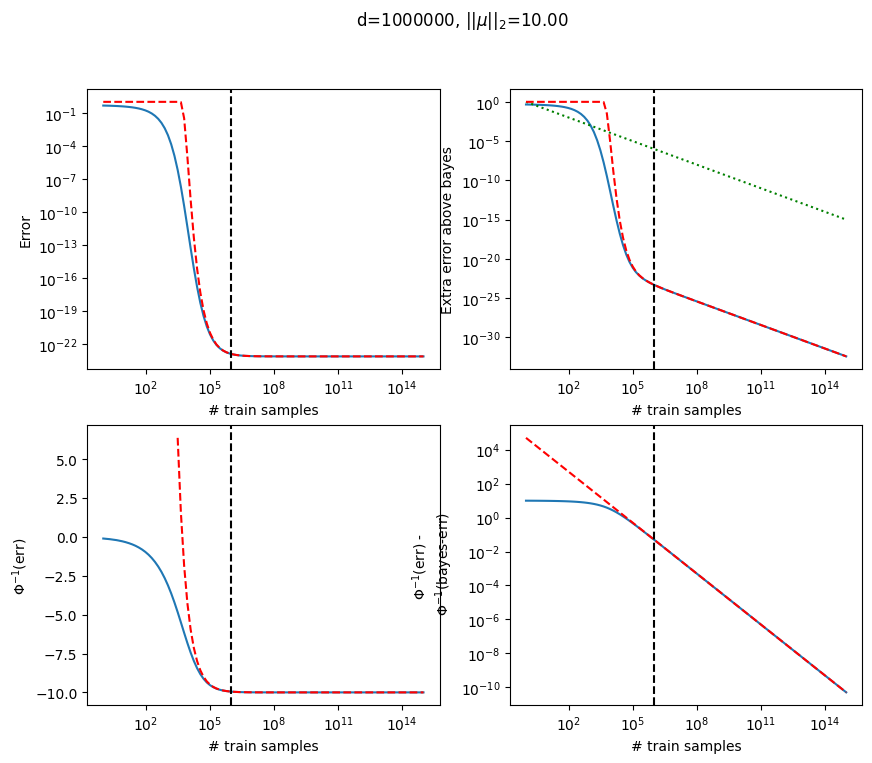

In [6]:
plt.figure(figsize=(10, 8))
plt.suptitle(f"d={mu.shape[0]}, $||\\mu||_2$={np.linalg.norm(mu):.2f}")

plt.subplot(2, 2, 1)
plt.plot(df.n, df.err_mid)
plt.fill_between(
    df.n,
    df.err_lo,
    df.err_hi,
    alpha=0.5,
)
plt.plot(df.n, df.err_approx, color="red", linestyle="--")
plt.axvline(len(mu), color="black", linestyle="--")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("# train samples")
plt.ylabel("Error")

plt.subplot(2, 2, 2)
plt.plot(df.n, df.extra_err_mid)
plt.fill_between(
    df.n,
    df.extra_err_lo,
    df.extra_err_hi,
    alpha=0.5,
)
plt.plot(df.n, 1 / df.n, color="green", linestyle=":")
plt.plot(df.n, df.extra_err_approx, color="red", linestyle="--")
plt.axvline(len(mu), color="black", linestyle="--")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("# train samples")
plt.ylabel("Extra error above bayes")

plt.subplot(2, 2, 3)
plt.plot(df.n, -df.arg_mid)
plt.fill_between(
    df.n,
    -df.arg_lo,
    -df.arg_hi,
    alpha=0.5,
)
plt.plot(df.n[-df.arg_approx < 10], -df.arg_approx[-df.arg_approx < 10], color="red", linestyle="--")
plt.axvline(len(mu), color="black", linestyle="--")
plt.xscale("log")
plt.xlabel("# train samples")
plt.ylabel("$\\Phi^{-1}$(err)")

plt.subplot(2, 2, 4)
plt.plot(df.n, df.extra_arg_mid)
plt.fill_between(
    df.n,
    df.extra_arg_lo,
    df.extra_arg_hi,
    alpha=0.5,
)
plt.plot(df.n, df.extra_arg_approx, color="red", linestyle="--")
plt.axvline(len(mu), color="black", linestyle="--")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("# train samples")
plt.ylabel("$\\Phi^{-1}$(err) - \n $\\Phi^{-1}$(bayes-err)")

### Plots v2

In [7]:
np.random.seed(42)
d = 100000
s = 3
mu = np.ones(d) / np.sqrt(d) * s
ns = remove_duplicates(np.logspace(0, 15, 100, dtype=int))
df = run_experiment(mu, ns, n_trials=1000, fast=True)

100%|██████████| 98/98 [00:00<00:00, 666.78it/s]


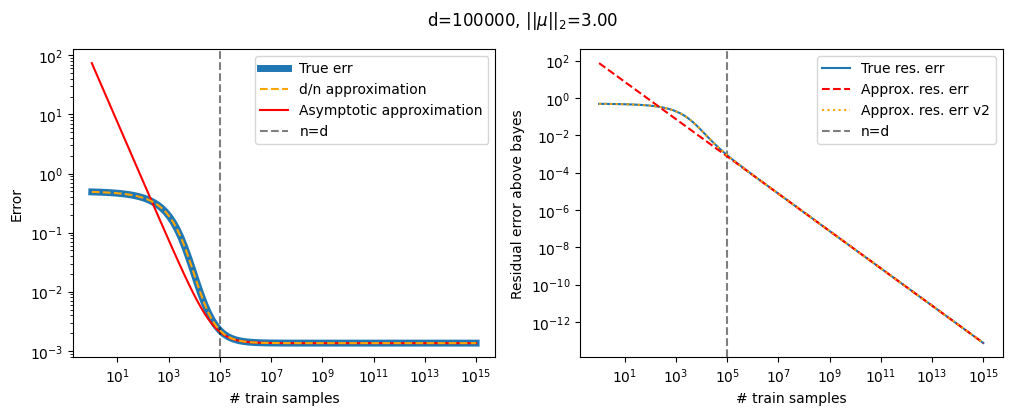

In [8]:
plt.figure(figsize=(12, 4))
plt.suptitle(f"d={mu.shape[0]}, $||\\mu||_2$={np.linalg.norm(mu):.2f}")

plt.subplot(1, 2, 1)
plt.plot(df.n, df.err_mid, label="True err", linewidth=5, zorder=-10,)
plt.fill_between(
    df.n,
    df.err_lo,
    df.err_hi,
    alpha=0.5,
    zorder=-11,
)
plt.plot(df.n, df.err_approx3, color="orange", linestyle="--", label="d/n approximation")
plt.plot(df.n, df.err_approx2, color="red", label="Asymptotic approximation", zorder=-5)
plt.axvline(len(mu), color="black", linestyle="--", alpha=0.5, zorder=-1, label="n=d")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("# train samples")
plt.ylabel("Error")
plt.legend();

plt.subplot(1, 2, 2)
plt.plot(df.n, df.extra_err_mid, label="True res. err")
plt.fill_between(
    df.n,
    df.extra_err_lo,
    df.extra_err_hi,
    alpha=0.5,
)
plt.plot(df.n, df.extra_err_approx2, color="red", linestyle="--", label="Approx. res. err")
plt.plot(df.n, df.extra_err_approx3, color="orange", linestyle=":", label="Approx. res. err v2")
plt.axvline(len(mu), color="black", linestyle="--", alpha=0.5, zorder=-1, label="n=d")
# plt.axvline(len(mu) ** 0.25, color="black", linestyle="--", alpha=0.5, zorder=-1)
s = np.linalg.norm(mu)
d = len(mu)
chi_med = scipy.stats.chi2.ppf(0.5, d - 1)
# plt.axhline(
#     np.exp(-s * s / 2) / np.sqrt(8 * np.pi) / s * chi_med / d,
#     color="black",
#     linestyle="--",
#     alpha=0.5,
#     zorder=-1,
# )
plt.xscale("log")
plt.yscale("log")
plt.xlabel("# train samples")
plt.ylabel("Residual error above bayes")
plt.legend();


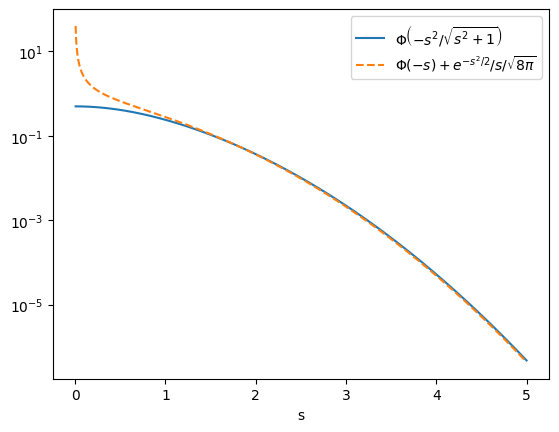

In [9]:
ss = np.linspace(0, 5, 1001)[1:]

xs1 = scipy.special.ndtr(-(ss * ss) / np.sqrt(ss * ss + 1))
xs2 = scipy.special.ndtr(-ss) + np.exp(-ss * ss / 2) / np.sqrt(8 * np.pi) / ss

plt.plot(ss, xs1, label="$\\Phi\\left(-s^2 / \\sqrt{s^2 + 1}\\right)$")
plt.plot(ss, xs2, label="$\\Phi(-s) + e^{-s^2/2} / s / \\sqrt{8 \pi}$", linestyle="--")
plt.legend()

plt.xlabel("s")
plt.yscale("log")

### Plots v3

In [10]:
ds = (10, 100, 10**4, 10**6)
ss = (0.1, 1, 3, 6)
ns = remove_duplicates(np.logspace(0, 12, 100, dtype=int))
n_trials = 10000

experiment_results = {}
for d in ds:
    for s in ss:
        mu = np.zeros(d)
        mu[0] = s
        experiment_results[(d, s)] = df = run_experiment(mu, ns, n_trials=n_trials, fast=True)

100%|██████████| 98/98 [00:00<00:00, 282.86it/s]


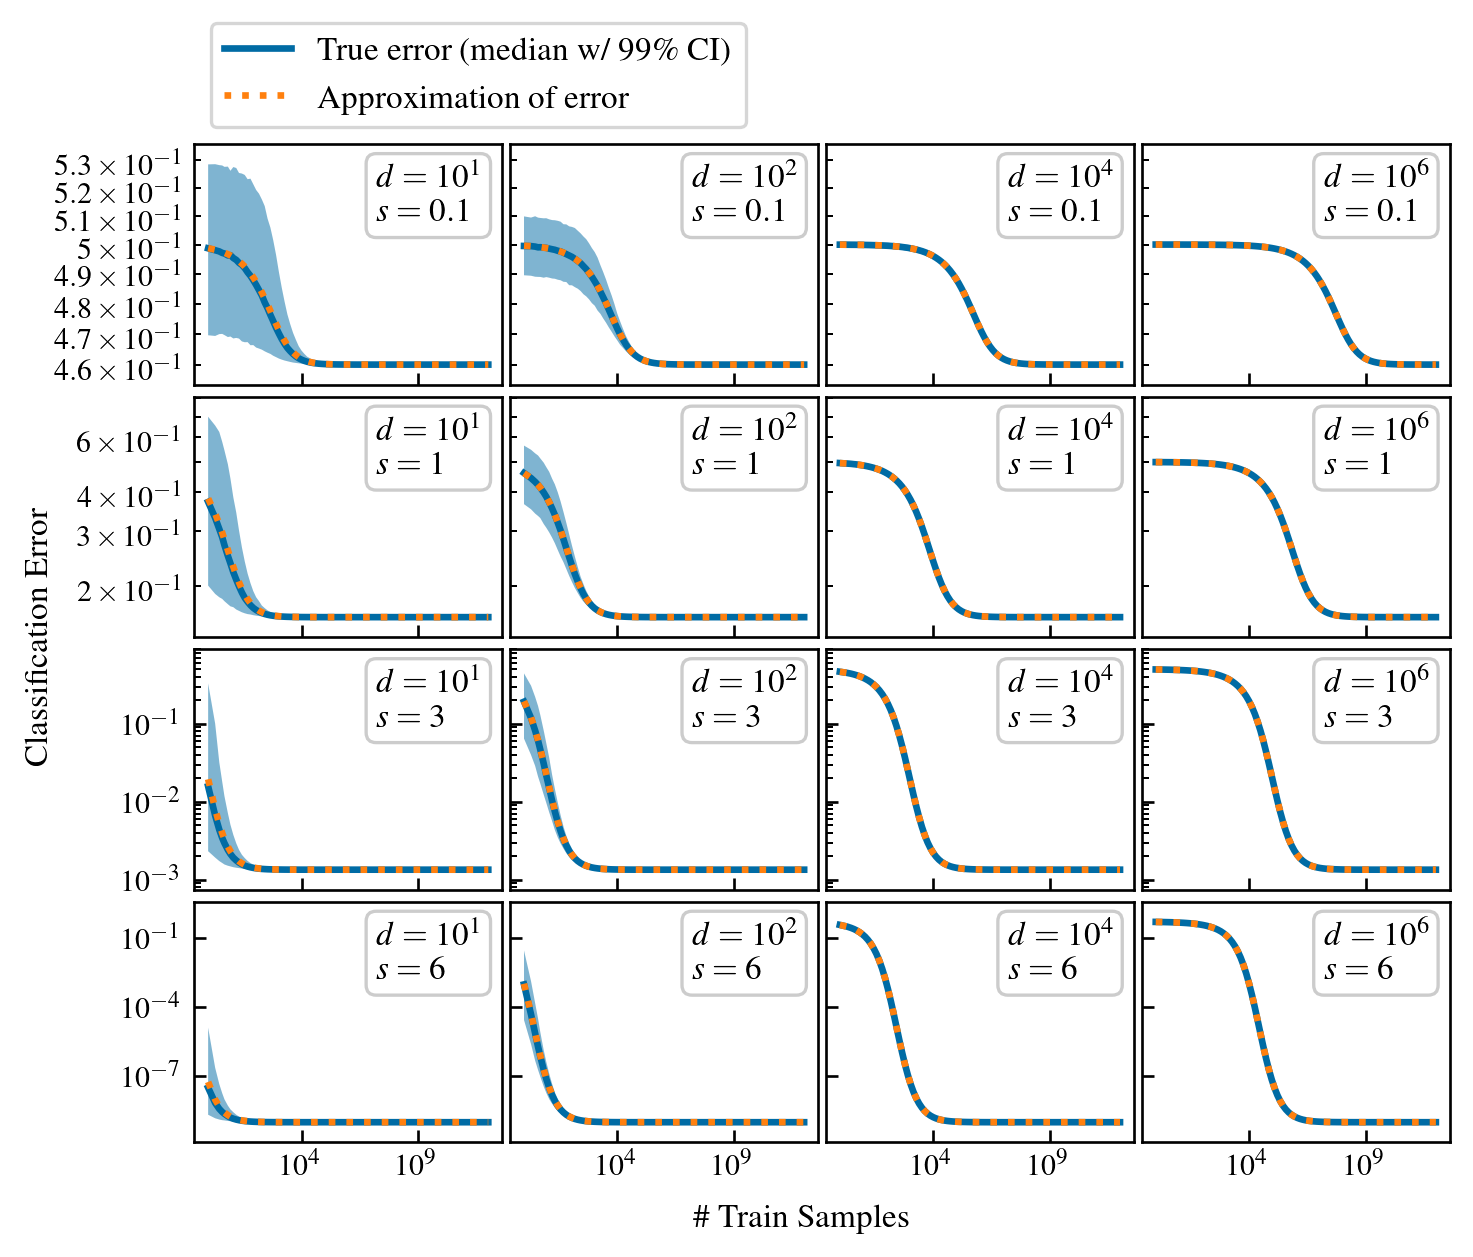

In [11]:
os.environ["LD_LIBRARY_PATH"] = ""  # Needed for latex to work
plt.style.use(
    [
        "tableau-colorblind10",
        stylesheets.ICLR_2023["mplstyle"],
        {
            "pgf.preamble": "\n".join(
                [r"\usepackage{amsmath}"]
            ),
        },
    ],
)
width = stylesheets.ICLR_2023["col1_width"]
fig = plt.figure(figsize=(width, width * 0.8))
plt.subplots_adjust(hspace=0.05, wspace=0.025)
fig.supxlabel("\# Train Samples", y=0.04)
fig.supylabel("Classification Error")

plot_idx = 1
for s in ss:
    ylo = min(experiment_results[(d, s)].err_lo.min() for d in ds)
    yhi = max(experiment_results[(d, s)].err_hi.max() for d in ds)

    for d in ds:
        ax = plt.subplot(len(ss), len(ds), plot_idx)
        ax.tick_params(direction="in", which="both")
        df = experiment_results[(d, s)]

        plt.plot(
            df.n,
            df.err_mid,
            linewidth=2,
            zorder=10,
            label="True error (median w/ 99\\% CI)",
        )
        plt.fill_between(
            df.n,
            df.err_lo,
            df.err_hi,
            alpha=0.5,
            zorder=5,
        )
        plt.plot(
            df.n,
            df.err_approx3,
            linestyle=":",
            linewidth=2,
            zorder=20,
            label="Approximation of error",
        )

        if plot_idx == 1:
            # Plot legend on top right with box
            plt.legend(loc="lower left", bbox_to_anchor=(0, 1), frameon=True)
        plt.title(
            f"$d=10^{int(np.log10(d))}$\n$s={s}$",
            # rf"\begin{{eqnarray*}} d &= 10^{int(np.log10(d))} \\ s &= {s} \end{{eqnarray*}}",
            y=0.6,
            x=0.76,
            bbox=dict(
                facecolor="none",
                edgecolor="black",
                alpha=0.2,
                boxstyle="round",
            ),
        ).set_multialignment("left")
        plt.xscale("log")
        plt.yscale("log")

        log_margin = (yhi / ylo) ** 0.1
        plt.ylim(ylo / log_margin, yhi * log_margin)

        # Show minor ticks for first two rows
        # if plot_idx <= len(ds) * 2:
        # ax.grid(visible=True, which="minor", axis="y")
        # Only show xticks on bottom row
        if plot_idx <= len(ds) * (len(ss) - 1):
            ax.axes.xaxis.set_ticklabels([])
        # Only show yticks on left column
        if plot_idx % len(ds) != 1:
            ax.axes.yaxis.set_ticklabels([])
            ax.axes.yaxis.set_ticklabels([], minor=True)

        plot_idx += 1

plt.savefig("figures/app-gaussian-plot-grid.pgf", bbox_inches="tight")